<a href="https://colab.research.google.com/github/AshJai23/JAIATD3/blob/main/BT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Step 1: Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# ✅ Step 2: Set dataset path and labels
data_path = "/content/drive/MyDrive/BTdataset"  # Update path if needed
classes = ['glioma', 'meningioma', 'pituitary']
img_size = (224, 224)

In [24]:
# ✅ Load and preprocess data
def load_data(data_path, classes, img_size):
    X, y = [], []
    for label, category in enumerate(classes):
        folder = os.path.join(data_path, category)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y)

X, y = load_data(data_path, classes, img_size)
X = preprocess_input(X.astype(np.float32))  # ResNet-specific preprocessing
y = to_categorical(y, num_classes=3)


In [25]:
# ✅ Step 4: Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42
)

In [26]:
# ✅ Data Augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
aug.fit(X_train)


In [27]:
# ✅ Step 6: Load ResNet50 + build model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# ✅ Compile
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# ✅ Step 7: Train the model (initial)
history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 62s 620ms/step - accuracy: 0.4178 - loss: 1.4633 - val_accuracy: 0.7406 - val_loss: 0.6909
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 395ms/step - accuracy: 0.6062 - loss: 0.9191 - val_accuracy: 0.8303 - val_loss: 0.5735
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 382ms/step - accuracy: 0.6664 - loss: 0.7725 - val_accuracy: 0.8336 - val_loss: 0.5139
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 382ms/step - accuracy: 0.7043 - loss: 0.7000 - val_accuracy: 0.8467 - val_loss: 0.4703
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 384ms/step - accuracy: 0.7429 - loss: 0.6291 - val_accuracy: 0.8418 - val_loss: 0.4396
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 394ms/step - accuracy: 0.7417 - loss: 0.6044 - val_accuracy: 0.8581 - val_loss: 0.4138
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 389ms/step - accuracy: 0.7539 - loss: 0.5876 - val_accuracy: 0.8369 - val_loss: 0.4176
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 385ms/step - accuracy: 0.7775 - loss: 0.5181 - val_accu

In [30]:
# ✅ Step 8: Fine-tune the base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
fine_tune_history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 70s 648ms/step - accuracy: 0.7905 - loss: 0.5222 - val_accuracy: 0.8793 - val_loss: 0.3145
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 397ms/step - accuracy: 0.8104 - loss: 0.4399 - val_accuracy: 0.8989 - val_loss: 0.2754
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 415ms/step - accuracy: 0.8488 - loss: 0.3756 - val_accuracy: 0.9103 - val_loss: 0.2506
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 405ms/step - accuracy: 0.8532 - loss: 0.3509 - val_accuracy: 0.9168 - val_loss: 0.2419
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 423ms/step - accuracy: 0.8819 - loss: 0.2817 - val_accuracy: 0.9168 - val_loss: 0.2137
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 396ms/step - accuracy: 0.8895 - loss: 0.2576 - val_accuracy: 0.9233 - val_loss: 0.2053
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 405ms/step - accuracy: 0.9119 - loss: 0.2317 - val_accuracy: 0.9282 - val_loss: 0.1949
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 403ms/step - accuracy: 0.9058 - loss: 0.2343 - val_accu

In [31]:
# ✅ Step 9: Evaluate the model
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Final Test Accuracy: {round(acc * 100, 2)}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9396 - loss: 0.1730

✅ Final Test Accuracy: 93.8%


In [32]:
# ✅ Step 10: Classification report and F1 score
y_true = y_test.argmax(axis=1)
y_pred = model.predict(X_test).argmax(axis=1)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1 Score: {round(macro_f1, 4)}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.89      0.87      0.88       142
  meningioma       0.96      0.94      0.95       285
   pituitary       0.94      0.99      0.96       186

    accuracy                           0.94       613
   macro avg       0.93      0.93      0.93       613
weighted avg       0.94      0.94      0.94       613

Macro F1 Score: 0.931


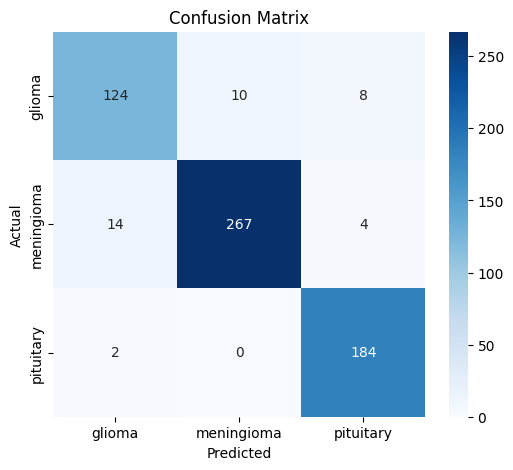

In [33]:
# ✅ Step 11: Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

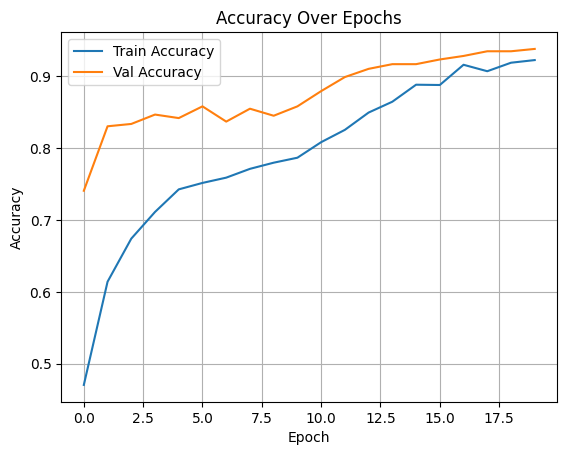

In [34]:
# ✅ Step 12: Plot accuracy and loss
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()